In [5]:
import pandas as pd

# Load your CSV file into a DataFrame
df = pd.read_csv('Customer Dataset 2.csv')

# Show first few rows to confirm it's loaded correctly
df.head()

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Groceries,113.53
1,2,21,Female,78852,60,2,42,Sports,41.93
2,3,60,Female,126573,30,2,28,Clothing,424.36
3,4,40,Other,47099,74,9,5,Home & Garden,991.93
4,5,65,Female,140621,21,3,25,Electronics,347.08


# Basis segmentasi: demografik

fitur yang relevan: age, gender, income

# Metode

1. Filter kolom yang relevan pada dataset
2. Hitung `n_clusters` optimal menggunakan elbow method
3. Hitung cluster menggunakan KMeans dengan `n_clusters` optimal
4. Fit RandomForestClassifier terhadap cluster tersebut
5. evaluasi (menggunakan `classification_report`)

In [7]:
df2=pd.DataFrame()
df2['age']=df['age']
df2['gender']=df['gender'].map({'Male':-1,'Female':1,'Other':0})
df2['income']=df['income']
df2=(df2-df2.mean())/df2.std()
df2.head()

,age,gender,income
0,-0.384451,1.269898,0.316709
1,-1.514604,1.269898,-0.281875
2,1.078099,1.269898,1.112222
3,-0.251492,0.050015,-1.209491
4,1.410497,1.269898,1.522613


spender_category
High    507
Low     493
Name: count, dtype: int64


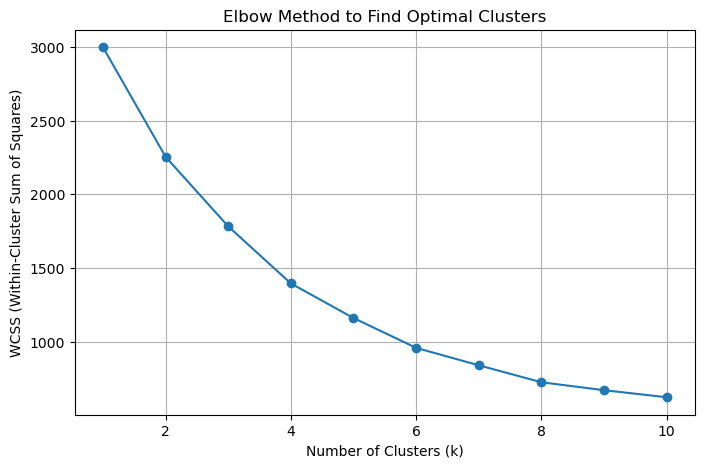

In [40]:
from sklearn.cluster import KMeans

# Define a simple rule for high/low spenders (adjust the threshold as needed)
df['spender_category'] = df['spending_score'].apply(lambda x: 'High' if x >= 50 else 'Low')

# Check the new column
print(df['spender_category'].value_counts())

# Find optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df2.values)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method to Find Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

## Hitung turunan absolut orde kedua

Nilai yang paling tinggi mengindikasikan kandidat bagus

In [38]:
pd.Series(wcss).diff().diff().abs()
#2 -> jumlah kluster terlalu kecil
#4 -> turunan ke-2 ke-2 paling besar, sehingga dipilih

0           NaN
1           NaN
2    271.365580
3     84.868028
4    152.187837
5     31.919438
6     84.296521
7      3.151107
8     60.968396
9      6.287615
dtype: float64

Kami pilih n_clusters = 4. Walaupun turunan absolut orde kedua-nya bukan paling tinggi, Ia kedua paling tinggi dan n_clusters-nya kami tidak ingin pilih yang terlalu rendah (seperti 2)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define features (including cluster labels) and target (spending_score or spender category)
X = df2
y = cluster  # Assuming high/low spender labels are already created

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.94      0.97        36
           2       0.96      0.96      0.96        48
           3       1.00      1.00      1.00        61

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



# Summary

`RandomForest` dengan 100 decision tree mendapatkan akurasi 98%, yakni Ia dapat meniru `KMeans(n_clusters=4)` dengan akurasi sebesar itu